In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import utils
import models

2022-04-09 15:02:14.822840: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-09 15:02:14.822878: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf.config.list_physical_devices()

2022-04-09 15:02:21.136020: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/franblue/anaconda3/envs/XAIFL/lib/python3.7/site-packages/cv2/../../lib64:
2022-04-09 15:02:21.136075: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-09 15:02:21.136109: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (frandd): /proc/driver/nvidia/version does not exist


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
MAIN_PATH = "/mnt/homeGPU/fcastro/lulc/"
MAIN_PATH = "/home/franblue/PROYECTOS/lulc/"


#data_dir = "../reduced_data/"
data_dir = MAIN_PATH + "data/"
batch_size = 32
img_height = 224
img_width = 224

load_model = False

#long_model_name = "mobilenetv3large_v3-1_ft1_DA4"
#long_model_name = "ensemble_waterpcasvm"
long_model_name = "ensemble_1"

weights_dir = MAIN_PATH + "weights/"
load_weights_file = f"{long_model_name}.h5"
load_weights_path = weights_dir + load_weights_file

submissions_dir = MAIN_PATH + "submissions/"
submissions_path = submissions_dir + f"{long_model_name}.csv"

#base_model_name = long_model_name.split("_")[0]
#top_model_name = long_model_name.split("_")[1]

In [4]:
test_data, test_labels, test_names = utils.load_test_data(data_dir, norm=False)
test_labels = tf.one_hot(test_labels, 29).numpy()

2022-04-09 15:02:24.745583: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
if load_model:
    prep_fn = models.get_prep_fn(base_model_name)
    if prep_fn is not None:
        test_data = prep_fn(test_data)
    model = models.build_model(base_model_name, top_model_name)
    model.load_weights(load_weights_path)

In [6]:
if load_model:
    preds = model.predict(test_data, batch_size)
    preds_argmax = np.argmax(preds, axis=-1)
    true_labels = np.argmax(test_labels, axis=-1)

In [7]:
subm_df = pd.read_csv(submissions_path)
preds_argmax = np.array(subm_df['label'])
true_labels = np.array([s.split("_")[0] for s in list(subm_df['id.jpg'])], dtype=int)

In [13]:
acc = accuracy_score(true_labels, preds_argmax)
cm = confusion_matrix(true_labels, preds_argmax)
cm = np.array(cm)
cm = pd.DataFrame(cm)
cm = cm.set_axis(np.arange(1,30), 0)
cm = cm.set_axis(np.arange(1,30), 1)
print(acc)

0.9721878862793573


/home/franblue/anaconda3/envs/XAIFL/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.set_axis except for the argument 'labels' will be keyword-only
  """
/home/franblue/anaconda3/envs/XAIFL/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.set_axis except for the argument 'labels' will be keyword-only
  


In [9]:
cm.iloc[21,20]

26

<AxesSubplot:>

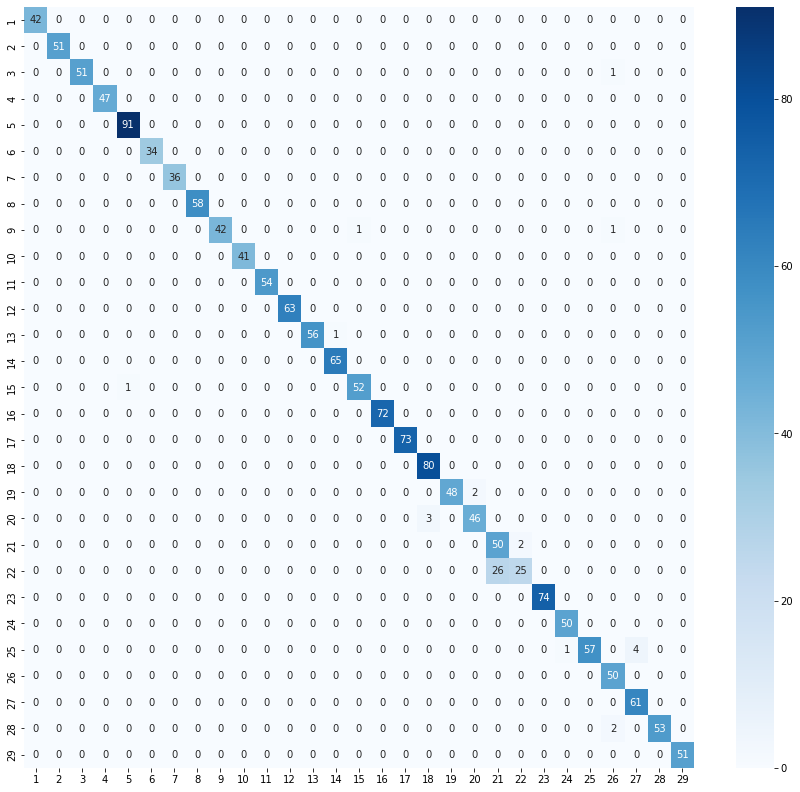

In [14]:
plt.figure(figsize = (15,14))
#sns.heatmap(cm/np.sum(cm, axis=1), annot=True, cmap="Blues")
sns.heatmap(cm, annot=True, cmap="Blues")

In [24]:
cr = classification_report(true_labels, preds_argmax, output_dict=True)

In [27]:
recall_vec = [cr[str(i)]['recall'] for i in range(1,30)]

<BarContainer object of 29 artists>

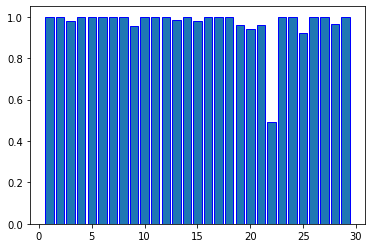

In [36]:
plt.bar(x=np.arange(1,30), height=recall_vec, edgecolor='b')

In [33]:
plt.bar(x=np.arange(1,30), y=recall_vec)

TypeError: bar() missing 1 required positional argument: 'height'

In [11]:
water_idx = np.logical_or(true_labels==21, true_labels==22)
water_labels = true_labels[water_idx]
water_preds = preds_argmax[water_idx]
print(classification_report(water_labels, water_preds))


              precision    recall  f1-score   support

          21       0.66      0.96      0.78        52
          22       0.93      0.49      0.64        51

    accuracy                           0.73       103
   macro avg       0.79      0.73      0.71       103
weighted avg       0.79      0.73      0.71       103

